# Exercise 5: Logistic Regression

This week's exercise is about linear classification, in particular, logistic regression. You will see both the binary and the multi-class variant of the logistic regression.

In [63]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# project files
import helpers as helpers


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Binary Class Logistic Regression

Let's start by loading the [_Iris Flower Dataset_](https://en.wikipedia.org/wiki/Iris_flower_data_set). To facilitate visualization, we will only use 2 out of the 4 features of this dataset. Furthermore, we will use 2 out of the 3 classes in this dataset, named *setosa* and *versicolor*. Therefore, for this part our dataset with two classes is as follows:

  - data: $\mathbf{X} \in \mathbb{R}^{N \times 3}$, $\forall \mathbf{x}_i \in \mathbf{X}: \mathbf{x}_i \in \mathbb{R}^{3}$ (2 features and the bias)
  - labels: $\mathbf{t} \in \mathbb{R}^{N}$, $\forall t_i \in \mathbf{t}: t_i \in \{0, 1\}$ 

**Note**:

**1.** We add here a bias term to our data. To simplify the notation, we directly consider it when we write the number of features $D$, so $D=2+1$ with 2 features and the bias.

**2.** $\mathbf{X}$ is a matrix of shape $N \times D$. However, a single data sample $\mathbf{x}_i$ is a column vector of shape $D \times 1$. 
To compute a scalar product of one data sample with the weight vector $\mathbf{w}$ (also a column vector of shape $D \times 1$), we write $\mathbf{x}_i^\top\mathbf{w}$. To perform a matrix-vector multiplication of the entire data matrix with the weight vector, we write $\mathbf{X}\cdot\mathbf{w}$.


**Q.** Verify that the dimensions match in the previous explanation, when using 1) a single data sample $\mathbf{x}_i$, and 2) the whole data matrix $\mathbf{X}$.

**A.**

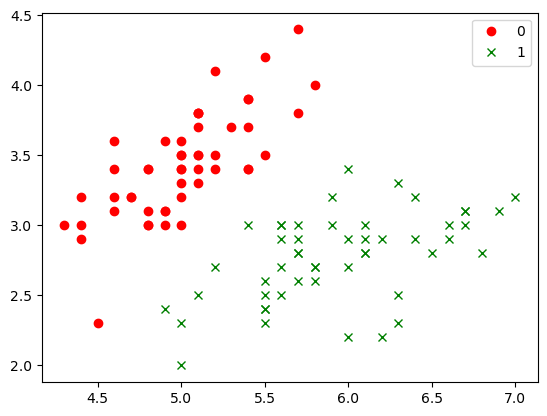

In [64]:
# Loads the data and split them into training and test subsets.
data, labels = helpers.load_ds_iris(sep_l=True, sep_w=True, pet_l=False, pet_w=False,
                                    setosa=True, versicolor=True, virginica=False, addbias=True)
fig = helpers.scatter2d_multiclass(data, labels)

num_samples = data.shape[0]

fraction_train = 0.8  # 80% of data is reserved for training, so 20% for testing
np.random.seed(0)
rinds = np.random.permutation(num_samples)  # shuffling of the indices to shuffle the data

n_train = int(num_samples * fraction_train)
data_train = data[rinds[:n_train]] 
labels_train = labels[rinds[:n_train]]  

data_test = data[rinds[n_train:]] 
labels_test = labels[rinds[n_train:]]  

## 1.1 A short introduction

In logistic regression, the probability of a datapoint belonging to a class is found as:
$$P(y_i=1|\mathbf{x}_i, \mathbf{w}) = \frac{1}{1+e^{-\mathbf{x}_i^{\top}\mathbf{w}}} $$

This is called the sigmoid function! The sigmoid function is defined as:
$$\sigma(a)= \frac{1}{1+e^{-a}}$$

So in our case, our model is defined as:
$$y(\mathbf{x}_i; \mathbf{w})=\sigma(\mathbf{x}_i^{\top}\mathbf{w})= \frac{1}{1+e^{-\mathbf{x}_i^{\top}\mathbf{w}}}$$



Let's try to code this function. You can use the numpy function `np.exp(x)` to take the exponential of a number.

In [65]:
def sigmoid(a):
    """
    Apply the sigmoid function to each element of an array.
    
    Args:
        a (array): Input data of shape (N,) 
    Returns:
        sigmoid(a) (array): Probabilites of shape (N,), where each value is in (0, 1).
    """
    ### WRITE YOUR CODE HERE

    return 1/(1+np.exp(-a))

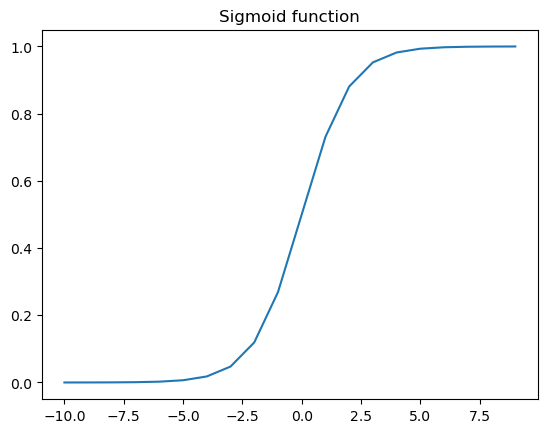

In [66]:
# TEST YOUR CODE
# Is the result what you expected?
x = np.arange(-10,10,1)
y = sigmoid(x)
plt.figure()
plt.title("Sigmoid function")
plt.plot(x,y); plt.show(); plt.close()

Recall that the cross entropy loss is defined as:
$$ \begin{align}
E(\mathbf{w}) &= -\sum_i \left\{t_i \ln{y_i} + (1-t_i) \ln{(1-y_i)}\right\} \\
y_i &= y(\mathbf{x}_i; \mathbf{w}) \end{align}$$

Let's code it using NumPy. You can use `np.log(x)` to compute $\ln{x}$, and the numpy function `np.dot()` or an operator `@` for matrix multiplication. (Recall that the operator `*` is an *element-wise* multiplication in numpy, not the matrix multiplication!)

In [67]:
def cross_entropy(data, labels, w): 
    """
    Cross-entropy loss for logistic regression on binary classes.
    
    Args:
        data (array): Dataset of shape (N, D).
        labels (array): Labels of shape (N,).
        w (array): Weights of logistic regression model of shape (D,)
    Returns:
        float: cross-entropy of the data
    """
    ### WRITE YOUR CODE HERE
    N = len(labels)

    # Calculate predicted probabilities
    y = 1 / (1 + np.exp(-np.dot(data, w)))
    return  -(1/N) * np.sum(labels*np.log(y) + (1-labels)*np.log(1-y))


In [68]:
# TEST YOUR CODE
utest_data = np.random.normal(size=(100,5))
utest_labels = np.random.binomial(n=1, p=0.5, size=utest_data.shape[0])
utest_w = np.random.normal(size=(utest_data.shape[1],))
utest_loss = cross_entropy(utest_data, utest_labels, utest_w)
print(utest_loss)  # this should print a single number, more or less around ~100

assert isinstance(utest_loss, float), "cross_entropy() does not return the correct format!"

0.9468251932704265


To move the weight vector towards the optimal weights, we need to compute the gradient of the loss function. This gradient is defined as
$$\nabla E(\mathbf{w}) = \sum_i (y_i - t_i)\mathbf{x}_i $$
Let us put this into a nice matrix format:
$$\nabla E(\mathbf{w})= \mathbf{X}^\top\left(\mathbf{y} - \mathbf{t}\right) = \mathbf{X}^\top\left(\sigma(\mathbf{X}\cdot\mathbf{w}) - \mathbf{t}\right),$$

where $\mathbf{y} = \sigma(\mathbf{X}\cdot \mathbf{w})$ are the predictions, and $\sigma(\mathbf{X}\cdot \mathbf{w})$ computes the sigmoid for each data sample separately, and returns a vector of shape $(N \times 1)$.


**Q.** What is the shape of $\nabla E(\mathbf{w})$? Does it match with the formula above?

**A.** 

Fill in the function for computing the gradient `gradient_cross_entropy()`. You can use the numpy function `np.dot()` or an operator `@` for matrix multiplication.

In [69]:
def gradient_cross_entropy(data, labels, w):
    """
    Gradient of the cross-entropy for logistic regression on binary classes.
    
    Args:
        data (array): Dataset of shape (N, D).
        labels (array): Labels of shape (N,).
        w (array): Weights of logistic regression model of shape (D,)
    Returns:
        grad (array): Gradient array of shape (D,)
    """
    ### WRITE YOUR CODE HERE
    # Calculate predicted probabilities
    y = 1 / (1 + np.exp(-np.dot(data, w)))

    # Compute gradient
    N = len(labels)
    grad = np.dot(data.T, y - labels) / N
    return grad


In [70]:
# TEST YOUR CODE
utest_grad = gradient_cross_entropy(utest_data, utest_labels, utest_w)
print(utest_grad)

assert (utest_grad.shape == utest_w.shape), "gradient_cross_entropy() does not return the correct format!"

[ 0.01301013  0.19318015  0.22767848 -0.19901695  0.04870584]


## 1.2 Classifying using a logistic regression model

Now let us write a function to perform classification using logistic regression, `logistic_regression_predict()`. This function uses the weights we find during training to predict the labels for the data.

**Hint:** We classify our data according to $P(y_i=1|\mathbf{x}_i, \mathbf{w})$. If the value of $P(y_i=1|\mathbf{x}_i, \mathbf{w})$ is less than 0.5 then the data point is classified as label 0. If it is more than or equal to 0.5 then we classify the data point as label 1.

In [71]:
def logistic_regression_predict(data, w):
    """ 
    Predict the label of data for binary class logistic regression. 
    
    Args:
        data (array): Dataset of shape (N, D).
        w (array): Weights of logistic regression model of shape (D,)
    Returns:
        predictions (array): Predicted labels of data, of shape (N,)
    """
    
    ### WRITE YOUR CODE HERE
    predictions = np.zeros(data.shape[0])

    for i,obj in enumerate(data) :
        prediction = sigmoid(np.dot(obj, w))

        if (prediction< 0.5):
            predictions[i] = 0
        else: 
            predictions[i]=1

    return predictions.astype(int)

In [72]:
utest_pred = logistic_regression_predict(utest_data, utest_w)
print(utest_pred)

assert (utest_pred.shape == utest_labels.shape), "logistic_regression_predict() does not return the correct format!"

[0 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0
 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1
 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1]


We measure the performance of our classifier with the *accuracy* metric. It is defined as 

$$ \text{Acc} = \frac{\text{\# correct predictions}}{\text{\# all predictions}}\cdot 100$$

Implement the following `accuracy_fn()` function using the predicted and ground truth labels.

In [73]:
def accuracy_fn(labels_pred, labels_gt):
    """
    Computes the accuracy of the predictions (in percent).
    
    Args:
        labels_pred (array): Predicted labels of shape (N,)
        labels_gt (array): GT labels of shape (N,)
    Returns:
        acc (float): Accuracy, in range [0, 1].
    """
    ### WRITE YOUR CODE HERE
    correct_counter = 0
    for i,pred in enumerate(labels_pred):
        if (labels_gt[i] == pred):
            correct_counter += 1

    return  100*correct_counter / len(labels_gt)

In [74]:
utest_labels1 = np.random.binomial(n=1, p=0.5, size=10)
utest_labels2 = np.random.binomial(n=1, p=0.5, size=10)                
utest_acc = accuracy_fn(utest_labels1, utest_labels2)
print(utest_acc)

assert isinstance(utest_acc, float) and (0 <= utest_acc <= 100), "accuracy_fn() does not return the correct format!"

60.0


## 1.3 Training a logistic regression model

To find the optimal weights for the given training data, we need to train our model. Fill in the missing parts of the function `logistic_regression_train()`.

The function first initializes the weights randomly (according to a Gaussian distribution). In each iteration, you should compute the gradient using `gradient_cross_entropy()` and take a gradient step to update the weights. Given that $\eta$ is the learning rate, recall that a gradient step is expressed as: 

$$ \mathbf{w}_{[t + 1]}  = \mathbf{w}_{[t]} - \eta\, \nabla E\left(\mathbf{w}_{[t]}\right) $$

The `loss`, `plot` and `print_every` parameters affect the way the loss is printed and the predictions are displayed. You do not need to modify these parts.



In [75]:
def logistic_regression_train(data, labels, max_iters=10, lr=0.001, 
                              print_period=1000, plot_period=1000):
    """
    Training function for binary class logistic regression. 
    
    Args:
        data (array): Dataset of shape (N, D).
        labels (array): Labels of shape (N,).
        max_iters (int): Maximum number of iterations. Default: 10
        lr (int): The learning rate of  the gradient step. Default: 0.001
        print_period (int): Number of iterations to print current loss. 
            If 0, never printed.
        plot_period (int): Number of iterations to plot current predictions.
            If 0, never plotted.
    Returns:
        weights (array): weights of the logistic regression model, of shape(D,)
    """
    # Initialize the weights randomly according to a Gaussian distribution
    weights = np.random.normal(0., 0.1, [data.shape[1],])
    for it in range(max_iters):
        ############# WRITE YOUR CODE HERE: find the gradient and do a gradient step
        gradient = gradient_cross_entropy(data,labels,weights)
        weights = weights - lr * (gradient)
        ##################################
        
        # If we reach 100% accuracy, we can stop training immediately
        predictions = logistic_regression_predict(data, weights)
        if accuracy_fn(predictions, labels) == 1:
            break
        # logging
        if print_period and it % print_period == 0:
            print('loss at iteration', it, ":", cross_entropy(data, labels, weights))
        # plotting
        if plot_period and it % plot_period == 0:
            fig = helpers.visualize_predictions(data=data, labels_gt=labels, labels_pred=predictions, title="iteration "+ str(it))
        
    fig = helpers.visualize_predictions(data=data, labels_gt=labels, labels_pred=predictions, title="final model")
    return weights

Run the code below to see your training in action. What do you observe? Try playing with the learning rate and number of max iterations.

*Hint:* we usually try different magnitude for the learning rate, such as 0.01, 0.001, 0.0001, etc.

If the code is very slow, verify if you used loops instead of leveraging numpy's efficient array computations.

In [ ]:
weights = logistic_regression_train(data_train, labels_train, max_iters=100000, lr=1e-2, print_period=1000, plot_period=3000)

Let's now use this trained model to make prediction on test data.

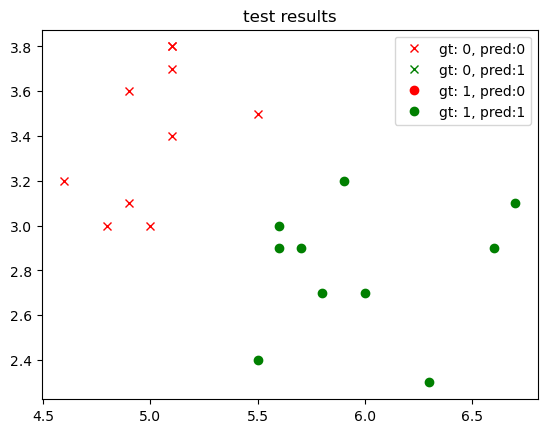

Test accuracy is 100.0%


In [77]:
predictions = logistic_regression_predict(data_test, weights)
fig = helpers.visualize_predictions(data=data_test, labels_gt=labels_test, labels_pred=predictions, title="test results")
print(f"Test accuracy is {accuracy_fn(predictions, labels_test)}%")

Now that we have classified two classes, we can move on to multi-class logistic regression!

# 2 Multi-Class Logistic Regression

Load the synthetic data by running the code segment below. We will use this dataset for now as it is easy to work with.
Our data is:

  - data: $\mathbf{X} \in \mathbb{R}^{N \times 3}$, $\forall \mathbf{x}_i \in \mathbf{X}: \mathbf{x}_i \in \mathbb{R}^{3}$ (2 features and the bias)
  - labels: $\mathbf{T} \in \mathbb{R}^{N\times C}$, $\forall \mathbf{t}_i \in \mathbf{T}: \mathbf{t}_i \in \mathbb{R}^{C}$ is a one-hot encoding of the label of a data sample, with $C$ the number of classes. $t_i^k$ is $1$ if $\mathbf{x}_i$ is of class $k$, otherwise $t_i^k=0$.

**A word on one-hot encoding:** the true labels $t_i\in\mathbf{t}$ can be integers, representing the class number in $\{0, 1, ..., C-1\}$, or they can be what we call *one-hot encoded*. This encoding consists in replacing the class number by a vector of dimension $C$ that is all $0$ except for the dimension that corresponds to the class where it is $1$. Let's give a few examples to explain: (considering $C=5$ classes)
* $t_i=0$ would become $\mathbf{t}_i = [1, 0, 0, 0, 0]^\top$
* $t_i=2$ would become $\mathbf{t}_i = [0, 0, 1, 0, 0]^\top$
* $t_i=4$ would become $\mathbf{t}_i = [0, 0, 0, 0, 1]^\top$

Such an encoding is both useful for simplifying some of the equations we use and has a nice geometric property: each class in this $C$-dimensional space is orthogonal and as "distant" to each other. With the integer representation, we have an order on the classes such as class $1$ is closer to class $0$ than class $2$ that may not have any meaning. The one-hot encoding removes such superfluous ordering.

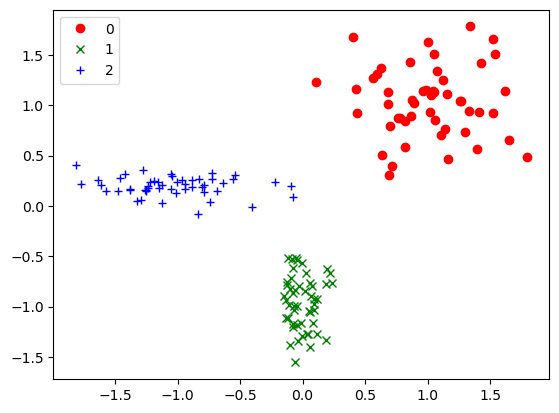

In [78]:
data_multi, labels_multi = helpers.load_dataset_synth(addbias=True)
fig = helpers.scatter2d_multiclass(data_multi, helpers.onehot_to_label(labels_multi), fig=None, fig_size=None, color_map=None,
                                   legend=True, legend_map=None, grid=False, show=False)

num_samples = data_multi.shape[0]

fraction_train = 0.8  # 80% of data is reserved for training, so 20% for testing
np.random.seed(0)
rinds = np.random.permutation(num_samples)  # shuffling of the indices to shuffle the data

n_train = int(num_samples * fraction_train)
data_train = data_multi[rinds[:n_train]] 
labels_train = labels_multi[rinds[:n_train]]  

data_test = data_multi[rinds[n_train:]] 
labels_test= labels_multi[rinds[n_train:]]  

## 2.1 A short introduction 

Multi-class logistic regression is an extension to binary logistic regression.

Let us consider logistic regression for $C$ classes. We keep our weights in a weight matrix $\mathbf{W}$, where every column is $\mathbf{w}_{(k)}$ for class $k$. Therefore, for every class $k$, we learn a separate weight vector $\mathbf{w}_{(k)}$ during training. The weights matrix will be of size $D \times C$.

The generalized probabilities for logistic regression are

$$y^{(k)}(\mathbf{x}_i) = P(y_i=k|\mathbf{x}_i, \mathbf{W}) = \frac{\exp{\mathbf{x}_i^\top \mathbf{w}_{(k)}}}{\sum_j^C \exp{\mathbf{x}_i^\top\mathbf{w}_{(j)}}},$$ 

which is called the **softmax** function! Let us denote this function by $f_\text{softmax}$. This is sort of an extension of the sigmoid function for the multi-class setting.

Fill in the implementation of this function below. It is used to assign the probabilities of a datapoint belonging to each class. For example, for a single datapoint and 3 classes you might have the following probability assignments: {0.2, 0.7, 0.1}. The probabilities all sum up to 1. 

In [79]:
def f_softmax(data, W):
    """
    Softmax function for multi-class logistic regression.
    
    Args:
        data (array): Input data of shape (N, D)
        W (array): Weights of shape (D, C) where C is the number of classes
    Returns:
        array of shape (N, C): Probability array where each value is in the
            range [0, 1] and each row sums to 1.
            The row i corresponds to the prediction of the ith data sample, and 
            the column j to the jth class. So element [i, j] is P(y_i=k | x_i, W)
    """
   


    norm_parameter = sum(W)
    normelized_data = np.exp( np.dot(data, W))/norm_parameter
    # Hint: try to decompose the above formula in different steps to avoid recomputing the same things.
    
    return normelized_data

In [80]:
# TEST YOUR CODE
utest_data = np.random.normal(size=(100,5))
utest_w = np.random.normal(size=(5,4))
utest_softmax = f_softmax(utest_data, utest_w)
print(utest_softmax.shape)


assert (utest_softmax.shape == (utest_data.shape[0], utest_w.shape[1])), "f_softmax() does not return the correct format!"

(100, 4)


Using these, we find the loss function which we are trying to minimize is

$$ E(\mathbf{W}) = - \sum_{i}^N \sum_{k}^N t_i^{(k)} \ln{\left(y^{(k)}(\mathbf{x}_i)\right)}, $$

where $y^{(k)}(\mathbf{x}_i)$ is the predicted probability of data sample $\mathbf{x}_i$ for class $k$, after using the *softmax*.

Fill in the loss function below.

In [95]:
def loss_logistic_multi(data, labels, w):
    """ 
    Loss function for multi class logistic regression, i.e., multi-class entropy.
    
    Args:
        data (array): Input data of shape (N, D)
        labels (array): Labels of shape  (N, C)  (in one-hot representation)
        w (array): Weights of shape (D, C)
    Returns:
        float: Loss value 
    """
    ### WRITE YOUR CODE HERE 

    Y = f_softmax(sigmoid(data), w)
    return -np.sum(labels * np.log(Y))




In [96]:
# TEST YOUR CODE
utest_labels = helpers.label_to_onehot(np.random.binomial(n=utest_w.shape[1]-1, p=0.5, size=100))
utest_loss = loss_logistic_multi(utest_data, utest_labels, utest_w)
print(utest_loss)  # this should print a single number, more or less around ~250

assert isinstance(utest_loss, float), "loss_logistic_multi() does not return the correct format!"

nan


/var/folders/k2/rdgqt18d2nncgf649_n52tph0000gp/T/ipykernel_78401/1887976388.py:15: RuntimeWarning: invalid value encountered in log
  return -np.sum(labels * np.log(Y))


To find the gradient, we find the gradient of $E(\mathbf{W})$ with respect to the weights $\mathbf{W}$. We have for each class weight $\mathbf{w}^{(k)}$:

$$\nabla E(\mathbf{w}^{(k)})=\sum_i^N \left(y^{(k)}(\mathbf{x}_i) - t_i^{(k)}\right) \mathbf{x}_{i},$$

or considering the full weight matrix $\mathbf{W}$:

$$\nabla E(\mathbf{W})=\sum_i^N \mathbf{x}_{i} \left(\mathbf{y}(\mathbf{x}_i) - \mathbf{t}_i\right)^\top ,$$

Let's put this into matrix format as well:

$$\nabla E(\mathbf{W})= \mathbf{X}^T(\mathbf{y}(\mathbf{X}) - \mathbf{T})$$

**A note on the notation:**   
Here, $\mathbf{y}(\mathbf{x}_i)$ returns the softmax result of shape $(C \times 1)$ for sample $\mathbf{x}_i$ and all classes. 

$\mathbf{y}(\mathbf{X})$ should return a matrix of shape $(N\times C)$, which consists of the softmax predictions for every sample for all classes. (The $i^{\mathrm{th}}$ row of $\mathbf{y}(\mathbf{X})$ is $\mathbf{y}(\mathbf{x}_i)$.)

Now, you will fill in the gradient function, `gradient_logistic_multi()` given below. 



In [115]:
def gradient_logistic_multi(data, labels, W):
    """
    Compute the gradient of the entropy for multi-class logistic regression.
    
    Args:
        data (array): Input data of shape (N, D)
        labels (array): Labels of shape  (N, C)  (in one-hot representation)
        W (array): Weights of shape (D, C)
    Returns:
        grad (np.array): Gradients of shape (D, C)
    """

    ### WRITE YOUR CODE HERE 
    Y = f_softmax(data, W )
    diff = Y - labels
    return np.dot(data.T, diff) / len(data) 

In [116]:
utest_grad = gradient_logistic_multi(utest_data, utest_labels, utest_w)
print(utest_grad.shape, "\n", utest_grad)

assert (utest_grad.shape == utest_w.shape), "gradient_logistic_multi() does not return the correct format!"

(5, 4) 
 [[  0.62479198  -1.51760909 -19.75493822   2.62067879]
 [ -0.04542839   3.21576466   4.37482726  -0.91137094]
 [  0.69121794   2.56284115  -1.46528343   2.27805208]
 [  0.60427697   0.24142046  24.91305955   1.00351096]
 [  0.19349269  -0.6608887   35.1514843    3.07334884]]


## 2.2 Classification and training for multiple classes

Write the functions for classification (predictions) and training.

Hints:
* For the classification function, you will be using $f_\text{softmax}$ to assign the probabilities of a datapoint belonging to each class. The softmax function returns an array of size $(N \times C)$.
* You will have to convert one-hot representation to labels (`np.argmax` is your friend). 

* Training will be the same as the binary case. First, we will find the gradient. Then we will update the weights using gradient descent.

In [127]:
def logistic_regression_predict_multi(data, W):
    """
    Prediction the label of data for multi-class logistic regression.
    
    Args:
        data (array): Dataset of shape (N, D).
        W (array): Weights of multi-class logistic regression model of shape (D, C)
    Returns:
        array of shape (N,): Label predictions of data.
    """
    ### WRITE YOUR CODE HERE
    
    
    probabilities = f_softmax(data, W)
    predictions = np.argmax(probabilities, axis=1)
    return predictions
    
    


In [140]:
def logistic_regression_train_multi(data, labels, max_iters=10, lr=0.001, 
                                    print_period=5, plot_period=5):
    """
    Training function for multi class logistic regression.
    
    Args:
        data (array): Dataset of shape (N, D).
        labels (array): Labels of shape (N, C)
        max_iters (int): Maximum number of iterations. Default: 10
        lr (int): The learning rate of  the gradient step. Default: 0.001
        print_period (int): Number of iterations to print current loss. 
            If 0, never printed.
        plot_period (int): Number of iterations to plot current predictions.
            If 0, never plotted.
    Returns:
        weights (array): weights of the logistic regression model, of shape(D, C)
    """
    D = data.shape[1]  # number of features
    C = labels.shape[1]  # number of classes
    # Random initialization of the weights
    weights = np.random.normal(0, 0.1, (D, C))
    for it in range(max_iters):
        ### WRITE YOUR CODE HERE
        grad = gradient_logistic_multi(data,labels,weights)
        weights -= lr * grad

        ##################################

        predictions = logistic_regression_predict_multi(data, weights)
        if accuracy_fn(predictions, helpers.onehot_to_label(labels)) == 1:
            break
        #logging and plotting
        if print_period and it % print_period == 0:
            print('loss at iteration', it, ":", loss_logistic_multi(data, labels, weights))
        if plot_period and it % plot_period == 0:
            fig = helpers.visualize_predictions(data=data, labels_gt=helpers.onehot_to_label(labels), labels_pred=predictions, title="iteration "+ str(it))
            
    fig = helpers.visualize_predictions(data=data, labels_gt=helpers.onehot_to_label(labels), labels_pred=predictions, title="final model")
    return weights

Run the code below to train the logistic regression model. What do you observe? Try playing with the learning rate and number of max iterations.

If the code is very slow, verify if you used loops instead of leveraging numpy's efficient array computations.

In [ ]:
weights_multi = logistic_regression_train_multi(data_train, labels_train, max_iters=20, lr=1e-3, print_period=5, plot_period=5)

Again, let's predict the test data.

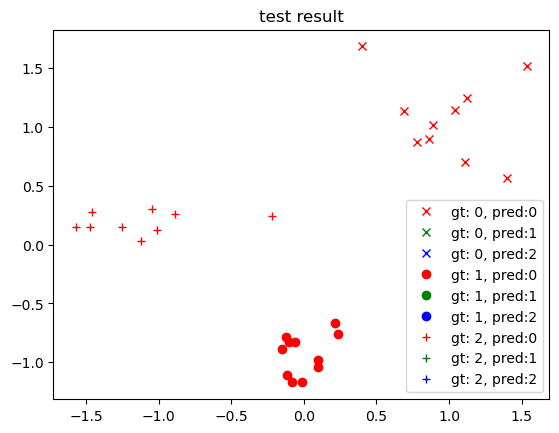

Test accuracy is 33.333333333333336%.


In [139]:
predictions_multi = logistic_regression_predict_multi(data_test, weights_multi)
fig = helpers.visualize_predictions(data=data_test, labels_gt=helpers.onehot_to_label(labels_test), labels_pred=predictions_multi, title="test result")
print(f"Test accuracy is {accuracy_fn(predictions_multi, helpers.onehot_to_label(labels_test))}%.")

**An (optional) side note:** Notice that using this simple formulation, we have trained C classifiers for C classes.
Our probability assignments are according to the softmax function.

$$P(\mathbf{y}_i=k|\mathbf{x}_i, \mathbf{W}) = \frac{\exp{\mathbf{x}_i^\top \mathbf{w}_{(k)}}}{\sum_j^C \exp{\mathbf{x}_i^\top\mathbf{w}_{(j)}}}$$

And 

$$\sum_{k}^{C} P(\mathbf{y}_i=k|\mathbf{x}_i, \mathbf{W}) = 1$$

However, in the binary case we were training $1$ classifier for $2$ classes. The probabilities are assigned according to the sigmoid function:

$$\begin{align}
P(\mathbf{y}_i=1|\mathbf{x}_i, \mathbf{w}) &= \frac{1}{1+\exp{-\mathbf{x}_i^\top \mathbf{w}}} \\
P(\mathbf{y}_i=0|\mathbf{x}_i, \mathbf{w}) &= 1-P(\mathbf{y}_i=1|\mathbf{x}_i, \mathbf{w}) = \frac{1}{1+\exp{\mathbf{x}_i^\top \mathbf{w}}}
\end{align}$$

Similar to the binary case, we can train $C-1$ classifiers for $C$ classes, instead of the $C$ we trained above. We modify the probability assignment function to be, for classes $k={1, ... ,C-1}$:

$$ P(\mathbf{y}_i=k|\mathbf{x}_i, \mathbf{W}) = \frac{\exp{\mathbf{x}_i^\top \mathbf{w}_{(k)}}}{1+\sum_j^{C-1} \exp{\mathbf{x}_i^\top \mathbf{w}_{(j)}}}. $$

**Q (optional).** What is $P(\mathbf{y}_i=0|\mathbf{x}_i, \mathbf{W})$?

**A.** 

Further reading: https://en.wikipedia.org/wiki/Multinomial_logistic_regression

# 3. Written questions

**Q1.** (MCQ) Considering logistic regression, select all of the correct statements below.
1. The cross-entropy loss is non convex with respect to the weight $\mathbf{w}$.
2. Logistic regression is generally more robust to outliers than linear regression for classification.

3. Logistic regression can be used to predict the value of someone's weight (in kilograms) based on their height (in meters).
4. For a binary classification problem, the value of $\sigma(\mathbf{x}^\top \mathbf{w})$, with $\sigma$ the sigmoid function, can be interpreted as the probability that $\mathbf{x}$ belongs to class $1$.

**A1.**



1. True. The cross-entropy loss is non-convex because it has multiple local minima. This can create problems for gradient-based optimization algorithms since they may converge to suboptimal minimizers depending on the initialization.

2. True. Logistic regression is based on a logistic function, which saturates at the extremes. Consequently, outliers have less influence on the decision boundary because their addition is unlikely to change the probability estimates.

3. False. Logistic regression is a classification model, not a regression model. It predicts the probability of an input belonging to a particular class, not a continuous output, like weight.

4. True. The sigmoid function squashes the output of a linear model to (0,1) taking the form $\sigma(\mathbf{x}^\top \mathbf{w})=\frac{1}{1+\exp(-\mathbf{x}^\top \mathbf{w})}$. The value of $\sigma(\mathbf{x}^\top \mathbf{w})$ can be seen as the probability that $\mathbf{x}$ belongs to class 1 in a binary classification problem.

**Q2.** Considering gradient descent on the cross-entropy $E(\mathbf{w})$ for logistic regression:   
a) Recall what is the formula to update the value of $\mathbf{w}$ using the gradient $\nabla E(\mathbf{w})$ without looking above.   
b) Generally speaking, what is gradient descent used for?   
c) What is the impact of $\eta$, the learning rate (too small or too large)?

**A2.** 

**Q3.** You have the following datasets with data points $\mathbf{x}\in\mathbb{R}^2$ and labels $y\in\{0,1\}$. The points of class $0$ are the circles, while points of class $1$ are the triangles. The filled points represent the train set while the empty ones are the test set.

<img src="img/logreg_q3.png" width=100%>

For each dataset, how well do you expect logistic regression to perform on the test data? Why?

**A3.** 

3 becuase the logistic regration saperate the the obj and increasing the margin


**Q4.** (MCQ) Recall that the cross-entropy loss, used for multi-class logistic   regression, is defined as:
$$\begin{align}
    E(\mathbf{W}) = -\sum_{i=1}^N \sum_{k=1}^C t^{(k)}_i \ln y^{(k)}(\mathbf{x}_i),
\end{align}$$

where $N$ is the number of samples, $C$ is the number of classes, $\mathbf{x}_i$ is a data sample, $\mathbf{y}_i$ is a label (one-hot encoded) and $y^{(k)}(\mathbf{x}_i)$ is the predicted probability of sample $\mathbf{x}_i$ belonging to class $k$.

Which of the following statements are true for the cross-entropy loss?

1. The prediction $y(\mathbf{x}_i)$ is found by applying the softmax function to the output of a linear model $\mathbf{W}\mathbf{x}_i$.
2. It is not a differentiable loss function, therefore we cannot use gradient descent.
3. Since it does not have a closed form solution, we have to use an iterative optimization method such as gradient descent.
4. The loss is $0$ for samples where the label and the prediction are the same.
5. If sample $i$ belongs to class $2$, the loss is higher when the prediction is $\mathbf{y}_i = \begin{bmatrix}0&0&0&0&1\end{bmatrix}$(predicted as class $4$) than when the prediction is $\begin{bmatrix}0&1&0&0&0\end{bmatrix}$ (predicted as class $1$).
6. $\sum_{k=1}^C y^{(k)}(\mathbf{x}_i)=1$

**A4.** 